# Train/Test Split and Augmentations
<br>
In this notebook, you will find the splitting of our original dataset into 80% train and 20% test. From there we split the 80% train set to our "train_OS" set which contains an oversampling of bearish and bullish audios in order to balance the data because neutral audios contained more than 74% of our original dataset. 

To oversample we performed five methods of augmentation:
- Denoising
- Frequency masking
- Time masking
- Sample shifting

For each augmentation we took a 50% random sample from both the original audios and denoised audios, equating to a 100% augmentation for both the bullish and bearish classes. We also denoised a random sample of 17% neutral audios to make up for the difference in denoised verses original audios between bearish and bullish classes. 

The denoising was performed using the DTLN model (http://dx.doi.org/10.21437/Interspeech.2020-2631, full citation can be found in run cell), which was trained on 500 hours worth of data. The other augmentations were done using the "audiomentations" repository, found on GitHub (https://github.com/iver56/audiomentations).


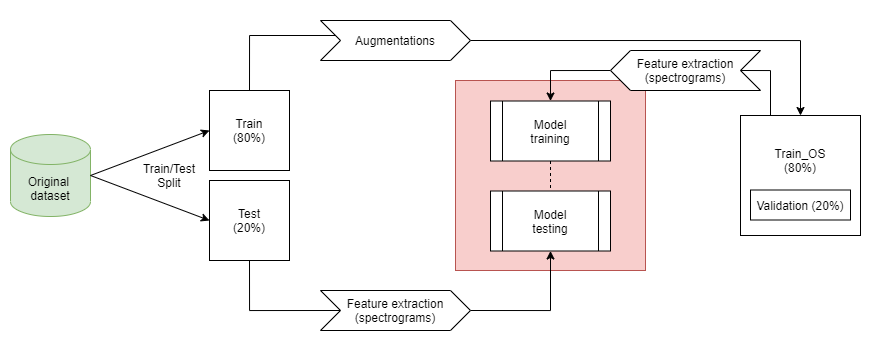

In [2]:
import pandas as pd
import numpy as np

import librosa
import librosa.display
import soundpy as sp
import soundfile as sf
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob
import sys
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('notebook')
sns.set_style("ticks")

In [2]:
def fname_labels_to_df(data):

    file_names = []
    file_labels = []

    for file_group in data:
        f = file_group[0]
        file_names.append(f)

        l = file_group[1]
        file_labels.append(l)
        
    df = pd.DataFrame({'audio_file': file_names, 'label': file_labels})
    
    return df  

In [3]:
# Get percentage difference between classes
def get_change(current, previous):
    if current == previous:
        return 100.0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0

In [4]:
aud_df = pd.read_csv("./capstone-project-3/data/master_audio_df.csv")
aud_df.head()

,audio,sr,num_channels,dur_sec,format_type,bitdepth,labels
0,capstone-project-3/data/bear_label_wavs/BEAR_9...,16000,1,8.0,WAV,PCM_16,bear
1,capstone-project-3/data/bear_label_wavs/BEAR_4...,16000,1,8.0,WAV,PCM_16,bear
2,capstone-project-3/data/bear_label_wavs/BEAR_7...,16000,1,8.0,WAV,PCM_16,bear
3,capstone-project-3/data/bear_label_wavs/BEAR_5...,16000,1,8.0,WAV,PCM_16,bear
4,capstone-project-3/data/bear_label_wavs/BEAR_1...,16000,1,8.0,WAV,PCM_16,bear


In [5]:
# Splitting dataset (80/20)
train, test, val = sp.datasets.waves2dataset(aud_df[['audio', 'labels']], val=False, perc_train=0.8)

print("Total audios in train set:", len(train),
      "\nTotal audios in validation set:", len(val),
      "\nTotal audios in test set:", len(test))

Total audios in train set: 141146 
Total audios in validation set: 0 
Total audios in test set: 35287


In [6]:
train_df = fname_labels_to_df(train)
test_df = fname_labels_to_df(test)

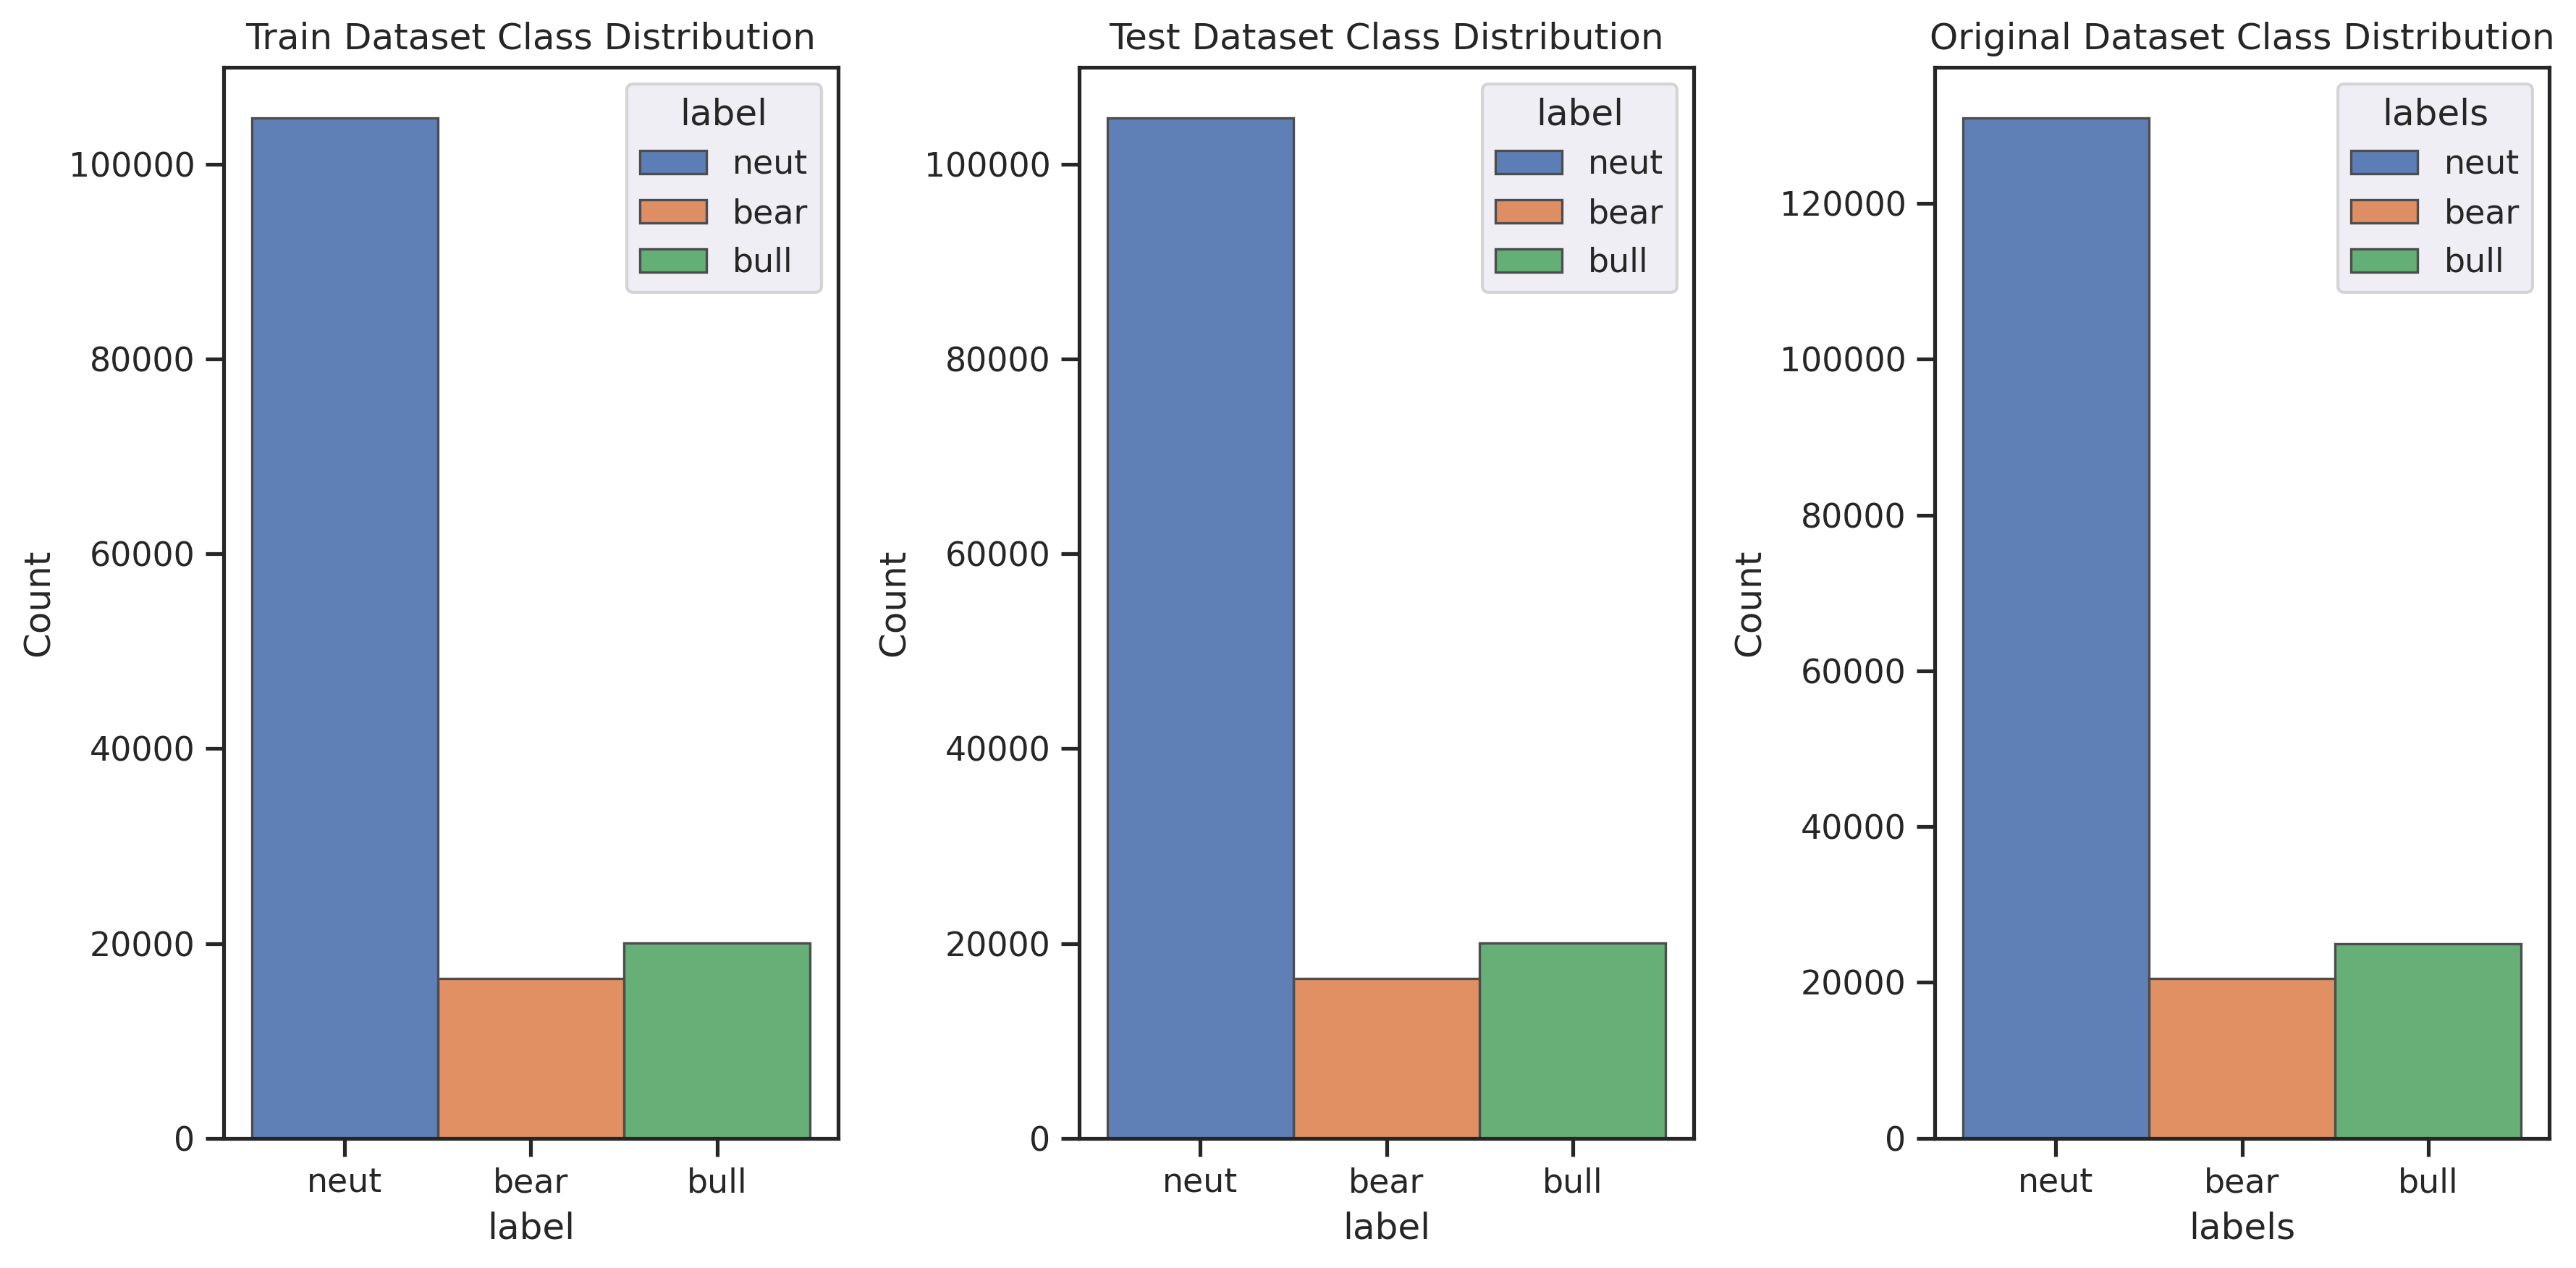

Original Dataset Class Distribution:
 
Neutral audios make up 74.204% of the dataset 
Bearish audios make up 11.627% of the dataset 
Bullish audios make up 14.169% of the dataset 

Train Dataset Class Distribution:
 
Neutral audios make up 74.188% of the dataset 
Bearish audios make up 11.596% of the dataset 
Bullish audios make up 14.216% of the dataset 

Test Dataset Class Distribution:
 
Neutral audios make up 74.188% of the dataset 
Bearish audios make up 11.596% of the dataset 
Bullish audios make up 14.216% of the dataset 



In [7]:
# Plot train/test split distributions

train_df['label'] = pd.Categorical(train_df['label'], ['neut','bear','bull'])
aud_df['labels'] = pd.Categorical(aud_df['labels'], ['neut','bear','bull'])

fig, ax = plt.subplots(1,3, figsize=(12,6))
sns.set_theme(style="darkgrid")

#----Train Distribution----

sns.histplot(data=train_df,
            x="label",
            hue='label',
            hue_order = ['neut', 'bear', 'bull'],
            palette="deep",
            edgecolor=".3",
            linewidth=.8,
            alpha=0.9,
            ax=ax[0])

ax[0].set_title("Train Dataset Class Distribution")

#----Test Distribution----

sns.histplot(data=train_df,
            x="label",
            hue='label',
            hue_order = ['neut', 'bear', 'bull'],
            palette="deep",
            edgecolor=".3",
            linewidth=.8,
            alpha=0.9,
            ax=ax[1])

ax[1].set_title("Test Dataset Class Distribution")

#----Original Distribution----

sns.histplot(data=aud_df,
            x="labels",
            hue="labels",
            hue_order=['neut', 'bear', 'bull'],
            palette="deep",
            edgecolor=".3",
            linewidth=.8,
            alpha=0.9,
            ax=ax[2])

ax[2].set_title("Original Dataset Class Distribution")

plt.tight_layout()
plt.show()


label_group = aud_df.groupby('labels')
bear_label = label_group.get_group('bear')
bull_label = label_group.get_group('bull')
neut_label = label_group.get_group('neut')

b = get_change(len(bear_label), len(aud_df))
b = 100 - b
b2 = get_change(len(bull_label), len(aud_df))
b2 = 100 - b2
n = get_change(len(neut_label), len(aud_df))
n = 100 - n

t_label_group = train_df.groupby('label')
t_bear_label = t_label_group.get_group('bear')
t_bull_label = t_label_group.get_group('bull')
t_neut_label = t_label_group.get_group('neut')

t_b = get_change(len(t_bear_label), len(train_df))
t_b = 100 - t_b
t_b2 = get_change(len(t_bull_label), len(train_df))
t_b2 = 100 - t_b2
t_n = get_change(len(t_neut_label), len(train_df))
t_n = 100 - t_n

ts_label_group = train_df.groupby('label')
ts_bear_label = ts_label_group.get_group('bear')
ts_bull_label = ts_label_group.get_group('bull')
ts_neut_label = ts_label_group.get_group('neut')

ts_b = get_change(len(ts_bear_label), len(train_df))
ts_b = 100 - ts_b
ts_b2 = get_change(len(ts_bull_label), len(train_df))
ts_b2 = 100 - ts_b2
ts_n = get_change(len(ts_neut_label), len(train_df))
ts_n = 100 - ts_n

print("Original Dataset Class Distribution:\n",
      "\nNeutral audios make up", str(round(n, 3)) + "%", "of the dataset", "\n"
      "Bearish audios make up", str(round(b, 3)) + "%", "of the dataset", "\n"
      "Bullish audios make up", str(round(b2, 3)) + "%", "of the dataset", "\n")

print("Train Dataset Class Distribution:\n",
      "\nNeutral audios make up", str(round(t_n, 3)) + "%", "of the dataset", "\n"
      "Bearish audios make up", str(round(t_b, 3)) + "%", "of the dataset", "\n"
      "Bullish audios make up", str(round(t_b2, 3)) + "%", "of the dataset", "\n")

print("Test Dataset Class Distribution:\n",
      "\nNeutral audios make up", str(round(ts_n, 3)) + "%", "of the dataset", "\n"
      "Bearish audios make up", str(round(ts_b, 3)) + "%", "of the dataset", "\n"
      "Bullish audios make up", str(round(ts_b2, 3)) + "%", "of the dataset", "\n")

In [1]:
t_bearish_df = pd.DataFrame(t_bear_label)
t_bullish_df = pd.DataFrame(t_bull_label)
t_neutral_df = pd.DataFrame(t_neut_label)

In [20]:
# Function containing modified DTLN denoiser loop

# DTLN Model Citation
# ----------------------------
#    @inproceedings{Westhausen2020,
#      author={Nils L. Westhausen and Bernd T. Meyer},
#      title={{Dual-Signal Transformation LSTM Network for Real-Time Noise Suppression}},
#      year=2020,
#      booktitle={Proc. Interspeech 2020},
#      pages={2477--2481},
#      doi={10.21437/Interspeech.2020-2631},
#      url={http://dx.doi.org/10.21437/Interspeech.2020-2631}}
# ----------------------------

def denoise_audio(audio_list, label_list, output_path, model):

    # load model
    model = tf.saved_model.load(model)
    infer = model.signatures["serving_default"]
    
    #class_l = label_list.iloc[0]
    n = len(audio_list)
    
    for i, (audio_file, label) in enumerate(zip(audio_list.iloc[0:], label_list.iloc[0:])):
        
        class_l = label
        new_index = len(os.listdir(output_path))
        out_path = output_path + str(class_l) + str(new_index) + ".wav"
 
        block_len = 512
        block_shift = 128
        audio, fs = sf.read(audio_file)
        # check for sampling rate
        if fs != 16000:
            raise ValueError('This model only supports 16k sampling rate.')
        # preallocate output audio
        out_file = np.zeros((len(audio)))
        # create buffer
        in_buffer = np.zeros((block_len))
        out_buffer = np.zeros((block_len))
        # calculate number of blocks
        num_blocks = (audio.shape[0] -
                      (block_len - block_shift)) // block_shift


        # iterate over the number of blcoks
        block_idx = 0 
        for idx in range(num_blocks):
            # shift values and write to buffer
            in_buffer[:-block_shift] = in_buffer[block_shift:]
            in_buffer[-block_shift:] = audio[idx *
                                             block_shift:(idx * block_shift) +
                                             block_shift]
            # create a batch dimension of one
            in_block = np.expand_dims(in_buffer, axis=0).astype('float32')
            # process one block
            out_block = infer(tf.constant(in_block))['conv1d_1']
            # shift values and write to buffer
            out_buffer[:-block_shift] = out_buffer[block_shift:]
            out_buffer[-block_shift:] = np.zeros((block_shift))
            out_buffer += np.squeeze(out_block)
            # write block to output file
            out_file[idx * block_shift:(idx * block_shift) +
                     block_shift] = out_buffer[:block_shift]  
            block_idx+=1
        if new_index == n:
            break  
            
        # write to .wav file
        sf.write(str(out_path), out_file, fs)
        percent = i / n * 100
        print("", end=f"\rPercent complete: {round(percent, 2)} % --- File processed: {audio_file}      ")
        time.sleep(1)
        
    denoised_files = glob.glob(output_path + "*.wav", recursive=True)
    df = pd.DataFrame({'denoised_audio': denoised_files, 'label': label_list})
    print(f"\nTotal # of {class_l}ish audios denoised:", len(denoised_files)) 

    return df

In [26]:
# Denoised audio paths
t_bearish_denoise_path = './capstone-project-3/train_bearish_denoise/'
t_bullish_denoise_path = './capstone-project-3/train_bullish_denoise/'
t_neutral_denoise_path = './capstone-project-3/train_neutral_denoise/'

# Denoiser models
dtln = './capstone-project-3/DTLN/pretrained_model/dtln_saved_model'
dtln_norm_40 = './capstone-project-3/DTLN/pretrained_model/DTLN_norm_40h_saved_model'
dtln_norm_500 = './capstone-project-3/DTLN/pretrained_model/DTLN_norm_500h_saved_model'

In [23]:
t_bearish_denoised = denoise_audio(t_bearish_df['audio_file'], t_bearish_df['label'], t_bearish_denoise_path, dtln_norm_500)
t_bullish_denoised = denoise_audio(t_bullish_df['audio_file'], t_bullish_df['label'], t_bullish_denoise_path, dtln_norm_500)

Percent complete: 100.0 % --- File processed: capstone-project-3/data/bull_label_wavs/BULL_132236.wav      Total # of bullish audios denoised: 20065


In [45]:
# Function for denoising random sample of neutral audios
def aug_denoise_sample(df, k, output_path, model):
    # int(len(df.index) * k)
    s_df = df.sample(frac=k)
    print(len(s_df))
    
    aug_df = denoise_audio(s_df['audio_file'], s_df['label'], output_path, model)

    return aug_df

In [32]:
t_neutral_denoised_sample = aug_denoise_sample(t_neutral_df, 0.17, t_neutral_denoise_path, dtln_norm_500)

17801
Percent complete: 99.99 % --- File processed: capstone-project-3/data/neut_label_wavs/NEUT_68379.wav       Total # of neutish audios denoised: 17801


In [36]:
t_bearish_denoised.to_csv("./capstone-project-3/data/train_bearish_denoised.csv", index=False)
t_bullish_denoised.to_csv("./capstone-project-3/data/train_bullish_denoised.csv", index=False)
t_neutral_denoised_sample.to_csv("./capstone-project-3/data/train_neutralsample_denoised.csv", index=False)

In [198]:
# Augmentation functions

from audiomentations import Compose, Resample, FrequencyMask, Shift, TimeMask

#SAMPLE_RATE = 16000

aug_resample = Compose([
    Resample(min_sample_rate=8000, max_sample_rate=44100, p=1)
])

aug_shift = Compose([
    Shift(min_fraction=-0.5,
        max_fraction=0.5,
        rollover=True,
        p=1),
])

aug_freqmask = Compose([
    FrequencyMask(min_frequency_band=0.0, max_frequency_band=0.5, p=1)
])
    
aug_timemask = Compose([
    TimeMask(min_band_part=0.0, max_band_part=0.5, p=1)
])


def augment_audios(which_augmentation, audio_list, label_list, sr, output_path):
    
    n = len(audio_list)
    #print(len(n))
    
    for i, (audio, label) in enumerate(zip(audio_list.iloc[0:], label_list.iloc[0:])):
        
        class_l = label
        new_index = len(os.listdir(output_path))
        out_path = output_path + str(class_l) + str(new_index) + ".wav"
        
        y, sr = librosa.load(audio, sr=sr, mono=True)
        aug = which_augmentation(samples=y, sample_rate=sr)
     
        sf.write(str(out_path), aug, sr)
        percent = i / n * 100
        print("", end=f"\rPercent complete: {round(percent, 2)} % --- File processed: {audio}      ")
        time.sleep(1)
        
    augmented_files = glob.glob(output_path + "*.wav", recursive=True)
    df = pd.DataFrame({str(which_augmentation)+'_audio': augmented_files, 'label': label_list})
    print("\n")
    print(f"\nTotal # of {class_l}ish audios denoised:", len(augmented_files)) 
    
    return df

def aug_from_sample(which_augmentation, df, k, sr, output_path):
    # int(len(df.index) * k)
    s_df = df.sample(frac=k)
    print(len(s_df))
    
    aug_df = augment_audios(which_augmentation, s_df['audio_file'], s_df['label'], sr, output_path)

    return aug_df

def aug_from_denoisedSample(which_augmentation, df, k, sr, output_path):
    # int(len(df.index) * k)
    s_df = df.sample(frac=k)
    print(len(s_df))
    
    aug_df = augment_audios(which_augmentation, s_df['denoised_audio'], s_df['label'], sr, output_path)

    return aug_df

In [199]:
# Augmented audio paths
freqmask_bearish_path = './capstone-project-3/train_bearish_aug_freqmask/' # 50% from original wavs
freqmask_bearish_denoised_path = './capstone-project-3/train_bearish_denoised_aug_freqmask/' # 50% from denoised wavs
freqmask_bullish_path = './capstone-project-3/train_bullish_aug_freqmask/' # 50% from original wavs
freqmask_bullish_denoised_path = './capstone-project-3/train_bullish_denoised_aug_freqmask/' # 50% from denoised wavs

# Total freqmask audios --- 50% from original, 50% from denoised

shift_bearish_path = './capstone-project-3/train_bearish_aug_shift/' # 50% from original wavs
shift_bearish_denoised_path = './capstone-project-3/train_bearish_denoised_aug_shift/' # 50% from denoised wavs
shift_bullish_path = './capstone-project-3/train_bullish_aug_shift/' # 50% from original wavs
shift_bullish_denoised_path = './capstone-project-3/train_bullish_denoised_aug_shift/' # 50% from denoised wavs

# Total freqmask audios --- 50% from original, 50% from denoised

resamp_bearish_path = './capstone-project-3/train_bearish_aug_resample/' # 50% from original wavs
resamp_bearish_denoised_path = './capstone-project-3/train_bearish_denoised_aug_resample/' # 50% from denoised wavs
resamp_bullish_path = './capstone-project-3/train_bullish_aug_resample/' # 50% from original wavs
resamp_bullish_denoised_path = './capstone-project-3/train_bullish_denoised_aug_resample/' # 50% from denoised wavs

# Total freqmask audios --- 50% from original, 50% from denoised

timemask_bearish_path = './capstone-project-3/train_bearish_aug_timemask/' # 50% from original wavs
timemask_bearish_denoised_path = './capstone-project-3/train_bearish_denoised_aug_timemask/' # 50% from denoised wavs
timemask_bullish_path = './capstone-project-3/train_bullish_aug_timemask/' # 50% from original wavs
timemask_bullish_denoised_path = './capstone-project-3/train_bullish_denoised_aug_timemask/' # 50% from denoised wavs

# Total freqmask audios --- 50% from original, 50% from denoised

In [203]:
freqmask_bearish_orig = aug_from_sample(aug_freqmask, t_bearish_df, .50, 16000, freqmask_bearish_path)
freqmask_bearish_denoised = aug_from_denoisedSample(aug_freqmask, t_bearish_denoised, .50, 16000, freqmask_bearish_denoised_path)
freqmask_bullish_orig = aug_from_sample(aug_freqmask, t_bullish_df, .50, 16000, freqmask_bullish_path)
freqmask_bullish_denoised = aug_from_denoisedSample(aug_freqmask, t_bullish_denoised, .50, 16000, freqmask_bullish_denoised_path)

shift_bearish_orig = aug_from_sample(aug_shift, t_bearish_df, .50, 16000, shift_bearish_path)
shift_bearish_denoised = aug_from_denoisedSample(aug_shift, t_bearish_denoised, .50, 16000, shift_bearish_denoised_path)
shift_bullish_orig = aug_from_sample(aug_shift, t_bullish_df, .50, 16000, shift_bullish_path)
shift_bullish_denoised = aug_from_denoisedSample(aug_shift, t_bullish_denoised, .50, 16000, shift_bullish_denoised_path)

resamp_bearish_orig = aug_from_sample(aug_resample, t_bearish_df, .50, 16000, resamp_bearish_path)
resamp_bearish_denoised = aug_from_denoisedSample(aug_resample, t_bearish_denoised, .50, 16000, resamp_bearish_denoised_path)
resamp_bullish_orig = aug_from_sample(aug_resample, t_bullish_df, .50, 16000, resamp_bullish_path)
resamp_bullish_denoised = aug_from_denoisedSample(aug_resample, t_bullish_denoised, .50, 16000, resamp_bullish_denoised_path)

timemask_bearish_orig = aug_from_sample(aug_timemask, t_bearish_df, .50, 16000, timemask_bearish_path)
timemask_bearish_denoised = aug_from_denoisedSample(aug_timemask, t_bearish_denoised, .50, 16000, timemask_bearish_denoised_path)
timemask_bullish_orig = aug_from_sample(aug_timemask, t_bullish_df, .50, 16000, timemask_bullish_path)
timemask_bullish_denoised = aug_from_denoisedSample(aug_timemask, t_bullish_denoised, .50, 16000, timemask_bullish_denoised_path)

10032
Percent complete: 99.99 % --- File processed: ./capstone-project-3/train_bullish_denoise/bull9188.wav       


Total # of bullish audios denoised: 10032


In [205]:
# Function to create .csv 
def df_to_csv(df, path):
    df.columns = ["audio_file", 'label']
    df.reset_index(drop=True, inplace=True)
    df.to_csv(path, index=False)
    
    return df.head()

In [262]:
# Export augmented audios to .csv
df_to_csv(t_bearish_denoised, path='./capstone-project-3/data/train_bearish_denoised.csv')

,audio_file,label
0,./capstone-project-3/train_bearish_denoise/bea...,bear
1,./capstone-project-3/train_bearish_denoise/bea...,bear
2,./capstone-project-3/train_bearish_denoise/bea...,bear
3,./capstone-project-3/train_bearish_denoise/bea...,bear
4,./capstone-project-3/train_bearish_denoise/bea...,bear


In [263]:
# Append dataframes to each, create complete train_OS dataframe
train_OS_df4 = pd.DataFrame().append([
    train_df, freqmask_bearish_orig, freqmask_bearish_denoised,
    freqmask_bullish_orig, freqmask_bullish_denoised, shift_bearish_orig,
    shift_bearish_denoised, shift_bullish_orig, shift_bullish_denoised,
    t_neutral_denoised_sample, t_bullish_denoised, t_bearish_denoised,
])

train_OS_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286459 entries, 0 to 16366
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   audio_file  286459 non-null  object  
 1   label       286459 non-null  category
dtypes: category(1), object(1)
memory usage: 4.6+ MB


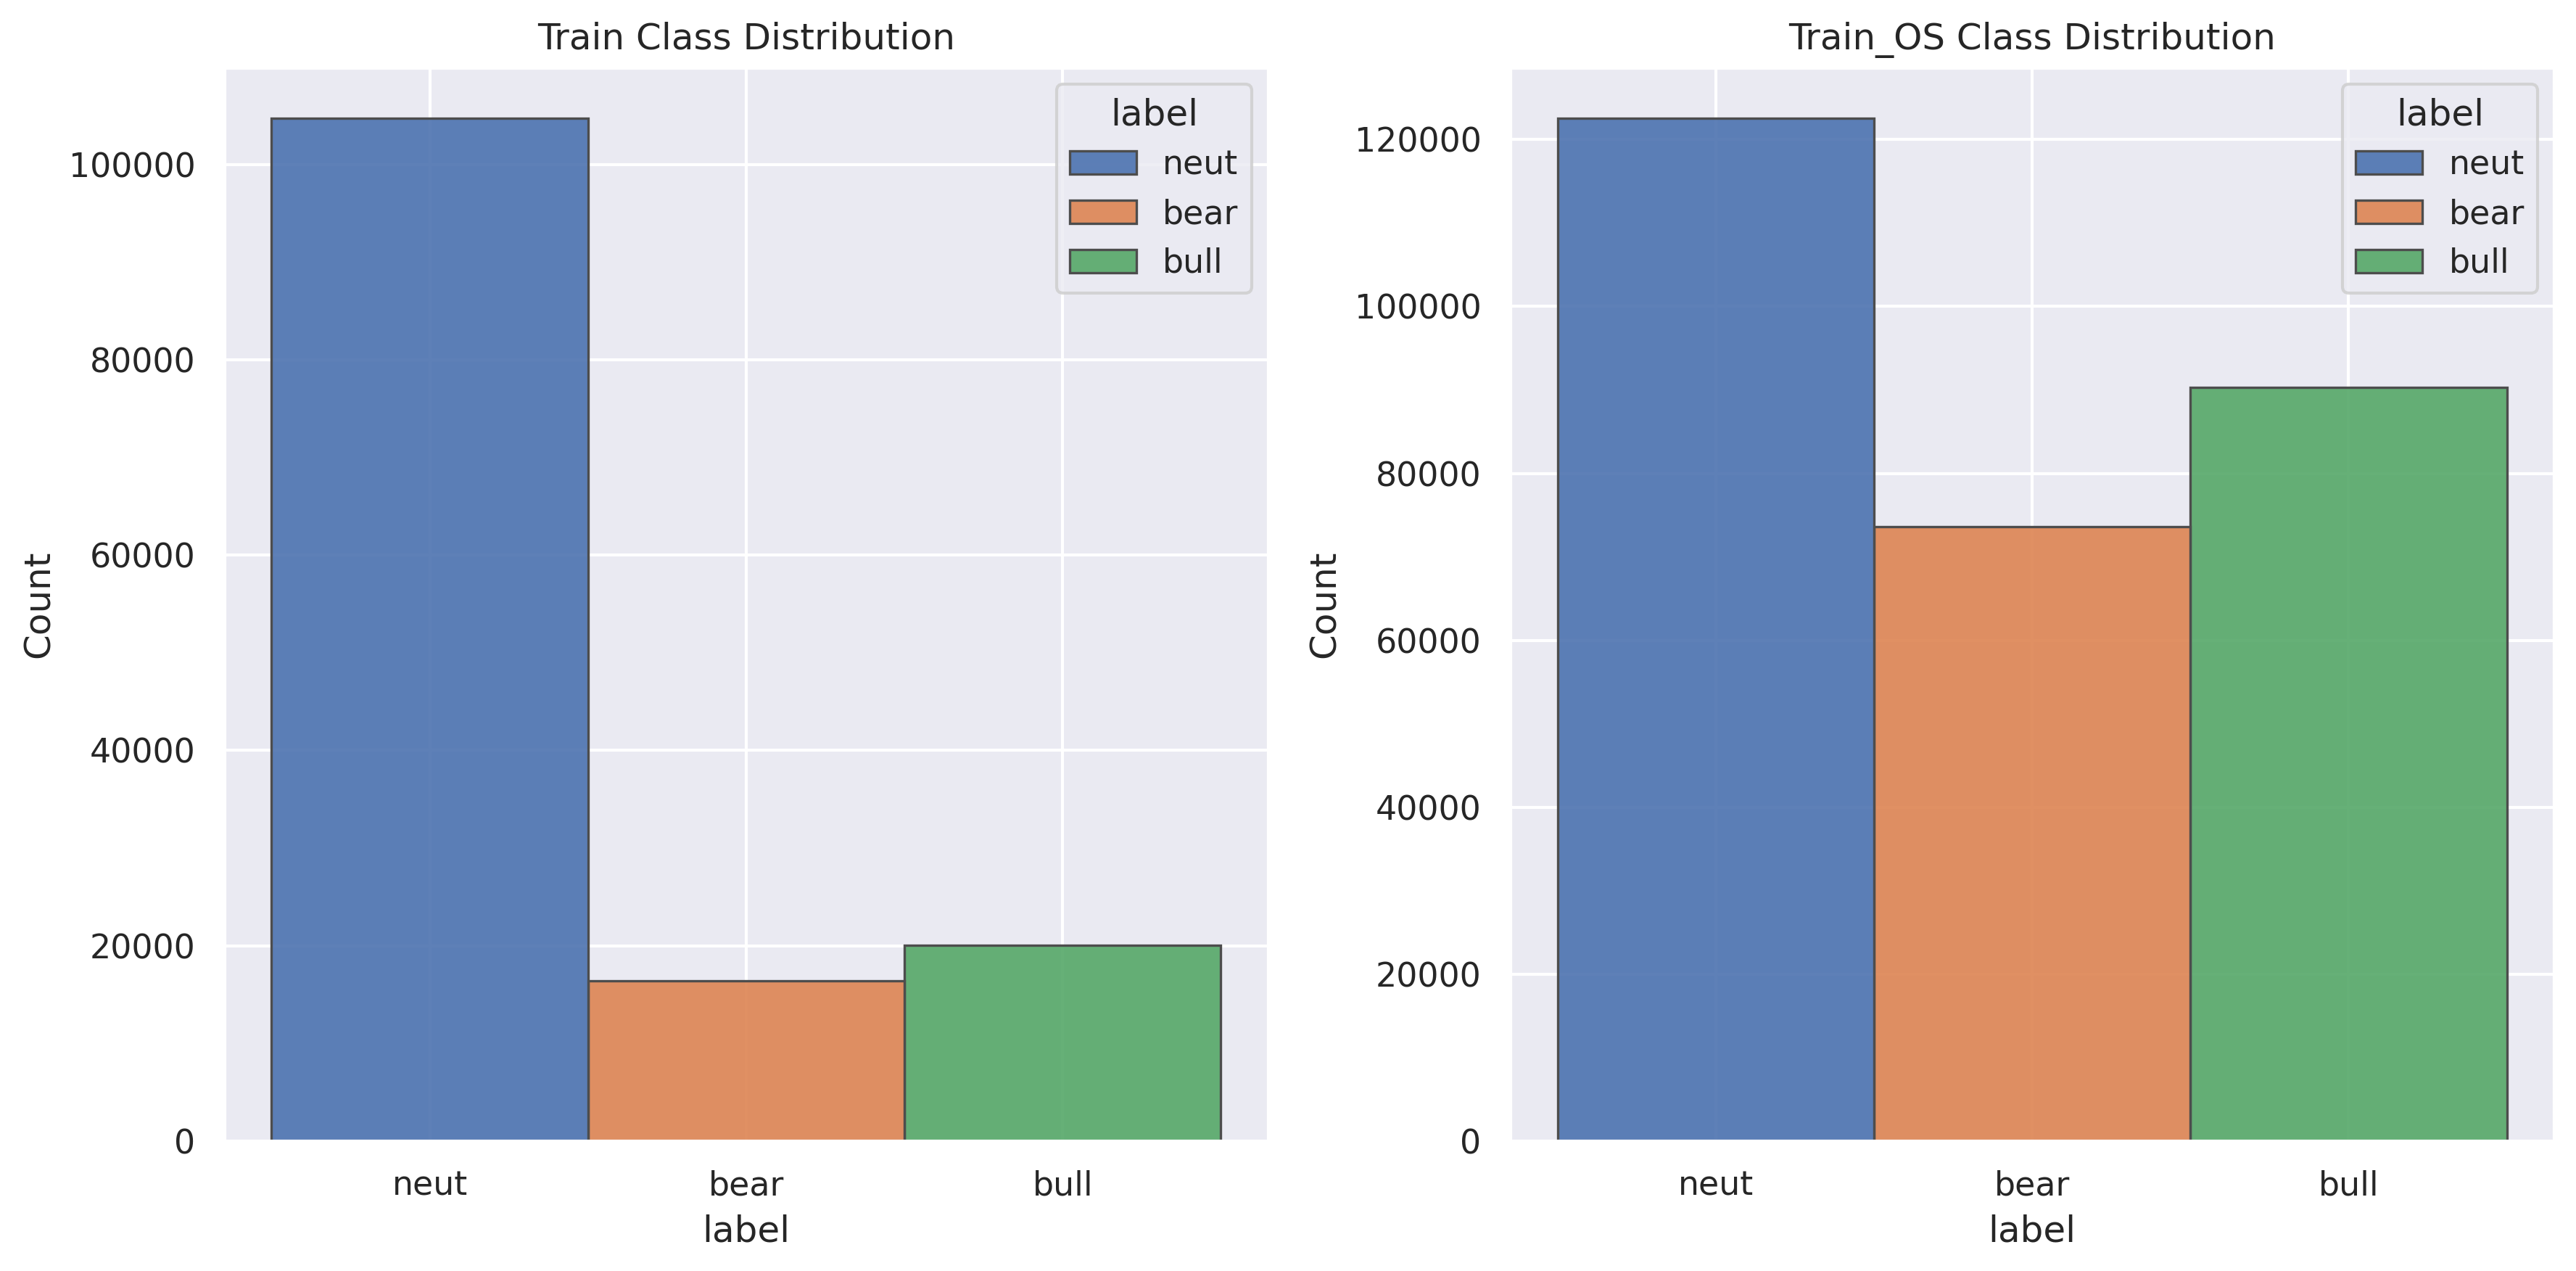

Train Class Distribution:
 
Neutral audios make up 74.188% of the dataset 
Bearish audios make up 11.596% of the dataset 
Bullish audios make up 14.216% of the dataset 

Total bearish audios: 16367 
Total bullish audios: 20065 
Total neutral audios: 104714 

Train_OS Class Distribution:
 
Neutral audios make up 42.769% of the dataset 
Bearish audios make up 77.145% of the dataset 
Bullish audios make up 71.983% of the dataset 

Total bearish audios: 65471 
Total bullish audios: 80257 
Total neutral audios: 122515


In [285]:
# Check new train distribution with plot

train_df['label'] = pd.Categorical(train_df['label'], ['neut','bear','bull'])
train_OS_df3['labels'] = pd.Categorical(train_OS_df3['label'], ['neut','bear','bull'])

fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.set_theme(style="darkgrid")

#----Train Distribution----

sns.histplot(data=train_df,
            x="label",
            hue='label',
            hue_order = ['neut', 'bear', 'bull'],
            palette="deep",
            edgecolor=".3",
            linewidth=.8,
            alpha=0.9,
            ax=ax[0])

ax[0].set_title("Train Class Distribution")

#----Train_OS Distribution----

sns.histplot(data=train_OS_df3,
            x="label",
            hue='label',
            hue_order = ['neut', 'bear', 'bull'],
            palette="deep",
            edgecolor=".3",
            linewidth=.8,
            alpha=0.9,
            ax=ax[1])

ax[1].set_title("Train_OS Class Distribution")

plt.tight_layout()
plt.show()


label_group = train_df.groupby('label')
bear_label = label_group.get_group('bear')
bull_label = label_group.get_group('bull')
neut_label = label_group.get_group('neut')

b = get_change(len(bear_label), len(train_df))
b = 100 - b
b2 = get_change(len(bull_label), len(train_df))
b2 = 100 - b2
n = get_change(len(neut_label), len(train_df))
n = 100 - n

t2_label_group = train_OS_df2.groupby('label')
t2_bear_label = t2_label_group.get_group('bear')
t2_bull_label = t2_label_group.get_group('bull')
t2_neut_label = t2_label_group.get_group('neut')

t2_b = get_change(len(t2_bear_label), len(train_OS_df3))
t_b = 100 - t2_b
t2_b2 = get_change(len(t2_bull_label), len(train_OS_df3))
t_b2 = 100 - t_b2
t2_n = get_change(len(t2_neut_label), len(train_OS_df3))
t2_n = 100 - t2_n


print("Train Class Distribution:\n",
      "\nNeutral audios make up", str(round(n, 3)) + "%", "of the dataset", "\n"
      "Bearish audios make up", str(round(b, 3)) + "%", "of the dataset", "\n"
      "Bullish audios make up", str(round(b2, 3)) + "%", "of the dataset", "\n"
      "\nTotal bearish audios:", len(bear_label), "\n"
      "Total bullish audios:", len(bull_label), "\n"
      "Total neutral audios:", len(neut_label), "\n")

print("Train_OS Class Distribution:\n",
      "\nNeutral audios make up", str(round(t2_n, 3)) + "%", "of the dataset", "\n"
      "Bearish audios make up", str(round(t2_b, 3)) + "%", "of the dataset", "\n"
      "Bullish audios make up", str(round(t2_b2, 3)) + "%", "of the dataset", "\n"
      "\nTotal bearish audios:", len(t2_bear_label), "\n"
      "Total bullish audios:", len(t2_bull_label), "\n"
      "Total neutral audios:", len(t2_neut_label))


In [59]:
import IPython

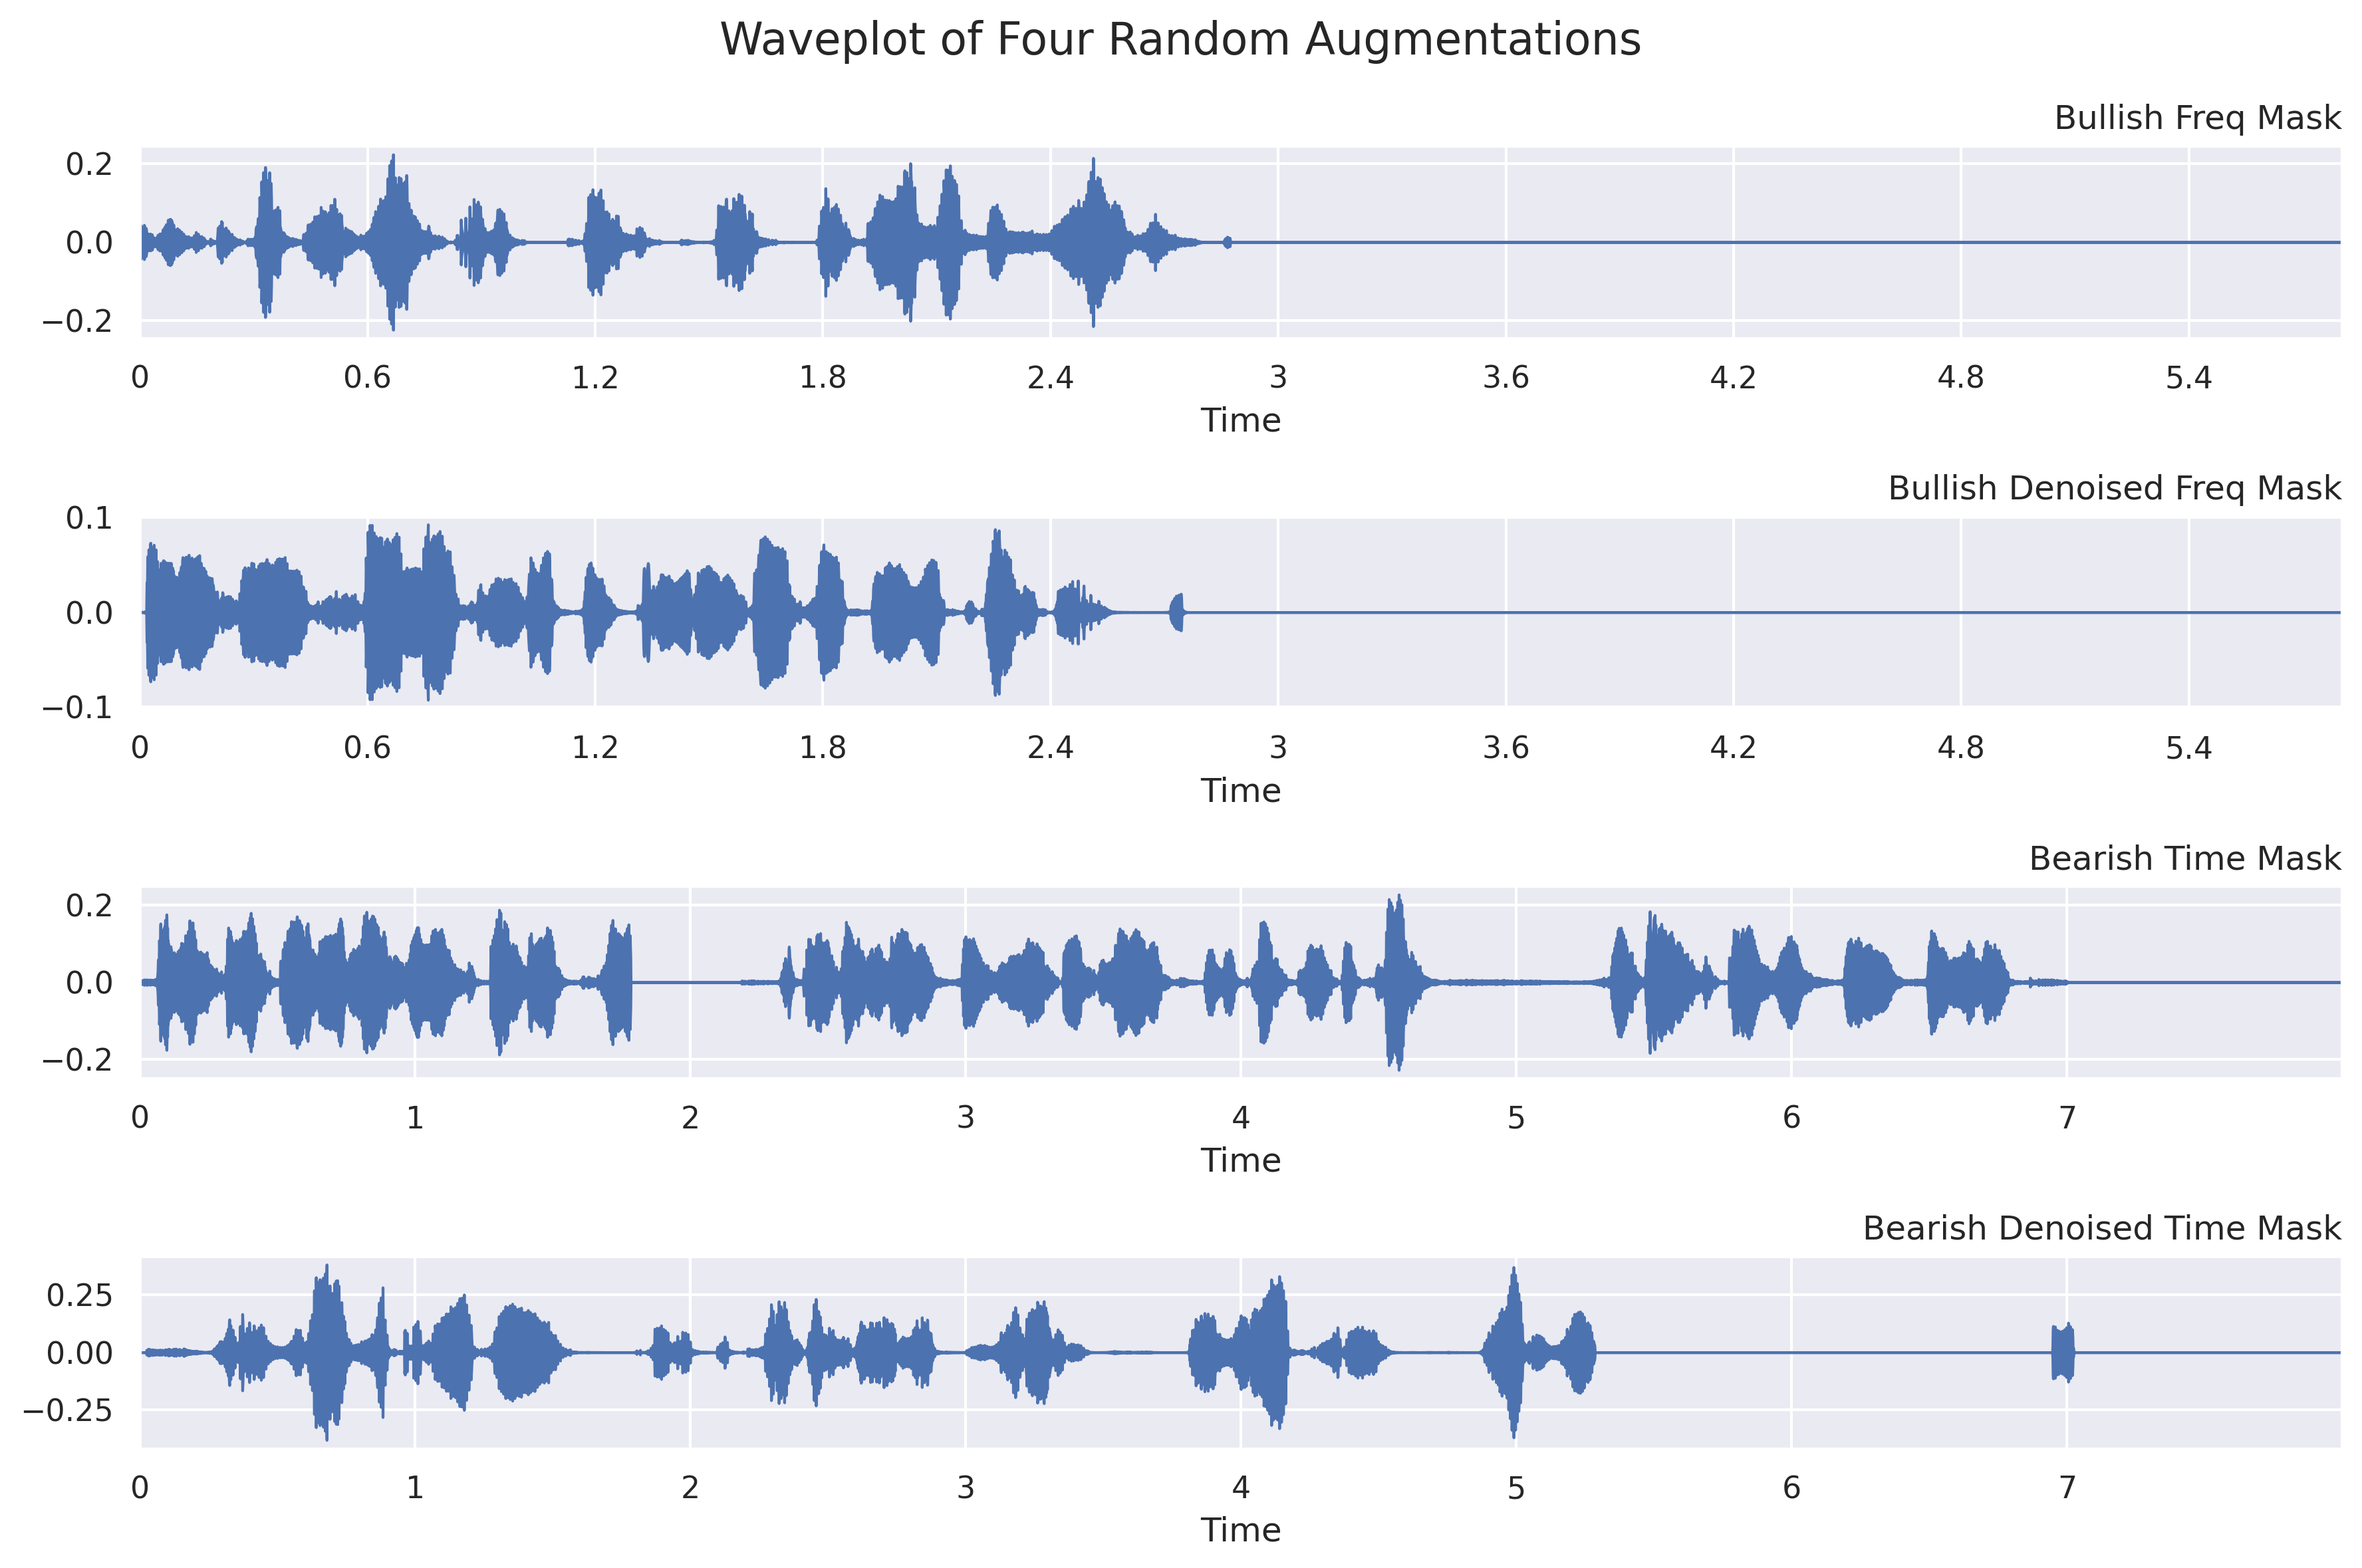

In [254]:
y1, sr = librosa.load(freqmask_bullish_orig['audio_file'].iloc[1539], sr=16000)
y2, sr = librosa.load(freqmask_bullish_denoised['audio_file'].iloc[3439], sr=16000)
y3, sr = librosa.load(timemask_bearish_orig['audio_file'].iloc[6754], sr=44100)
y4, sr = librosa.load(timemask_bearish_denoised['audio_file'].iloc[289], sr=44100)



plt.figure(figsize=(12,8))
plt.suptitle('Waveplot of Four Random Augmentations', fontsize=16)

plt.subplot(4, 1, 1)
librosa.display.waveplot(y1)
plt.title('Bullish Freq Mask', loc='right')

plt.subplot(4, 1, 2)
librosa.display.waveplot(y2)
plt.title('Bullish Denoised Freq Mask', loc='right')

plt.subplot(4, 1, 3)
librosa.display.waveplot(y3, sr=44100)
plt.title('Bearish Time Mask', loc='right')

plt.subplot(4, 1, 4)
librosa.display.waveplot(y4, sr=44100)
plt.title('Bearish Denoised Time Mask', loc='right')

plt.tight_layout()

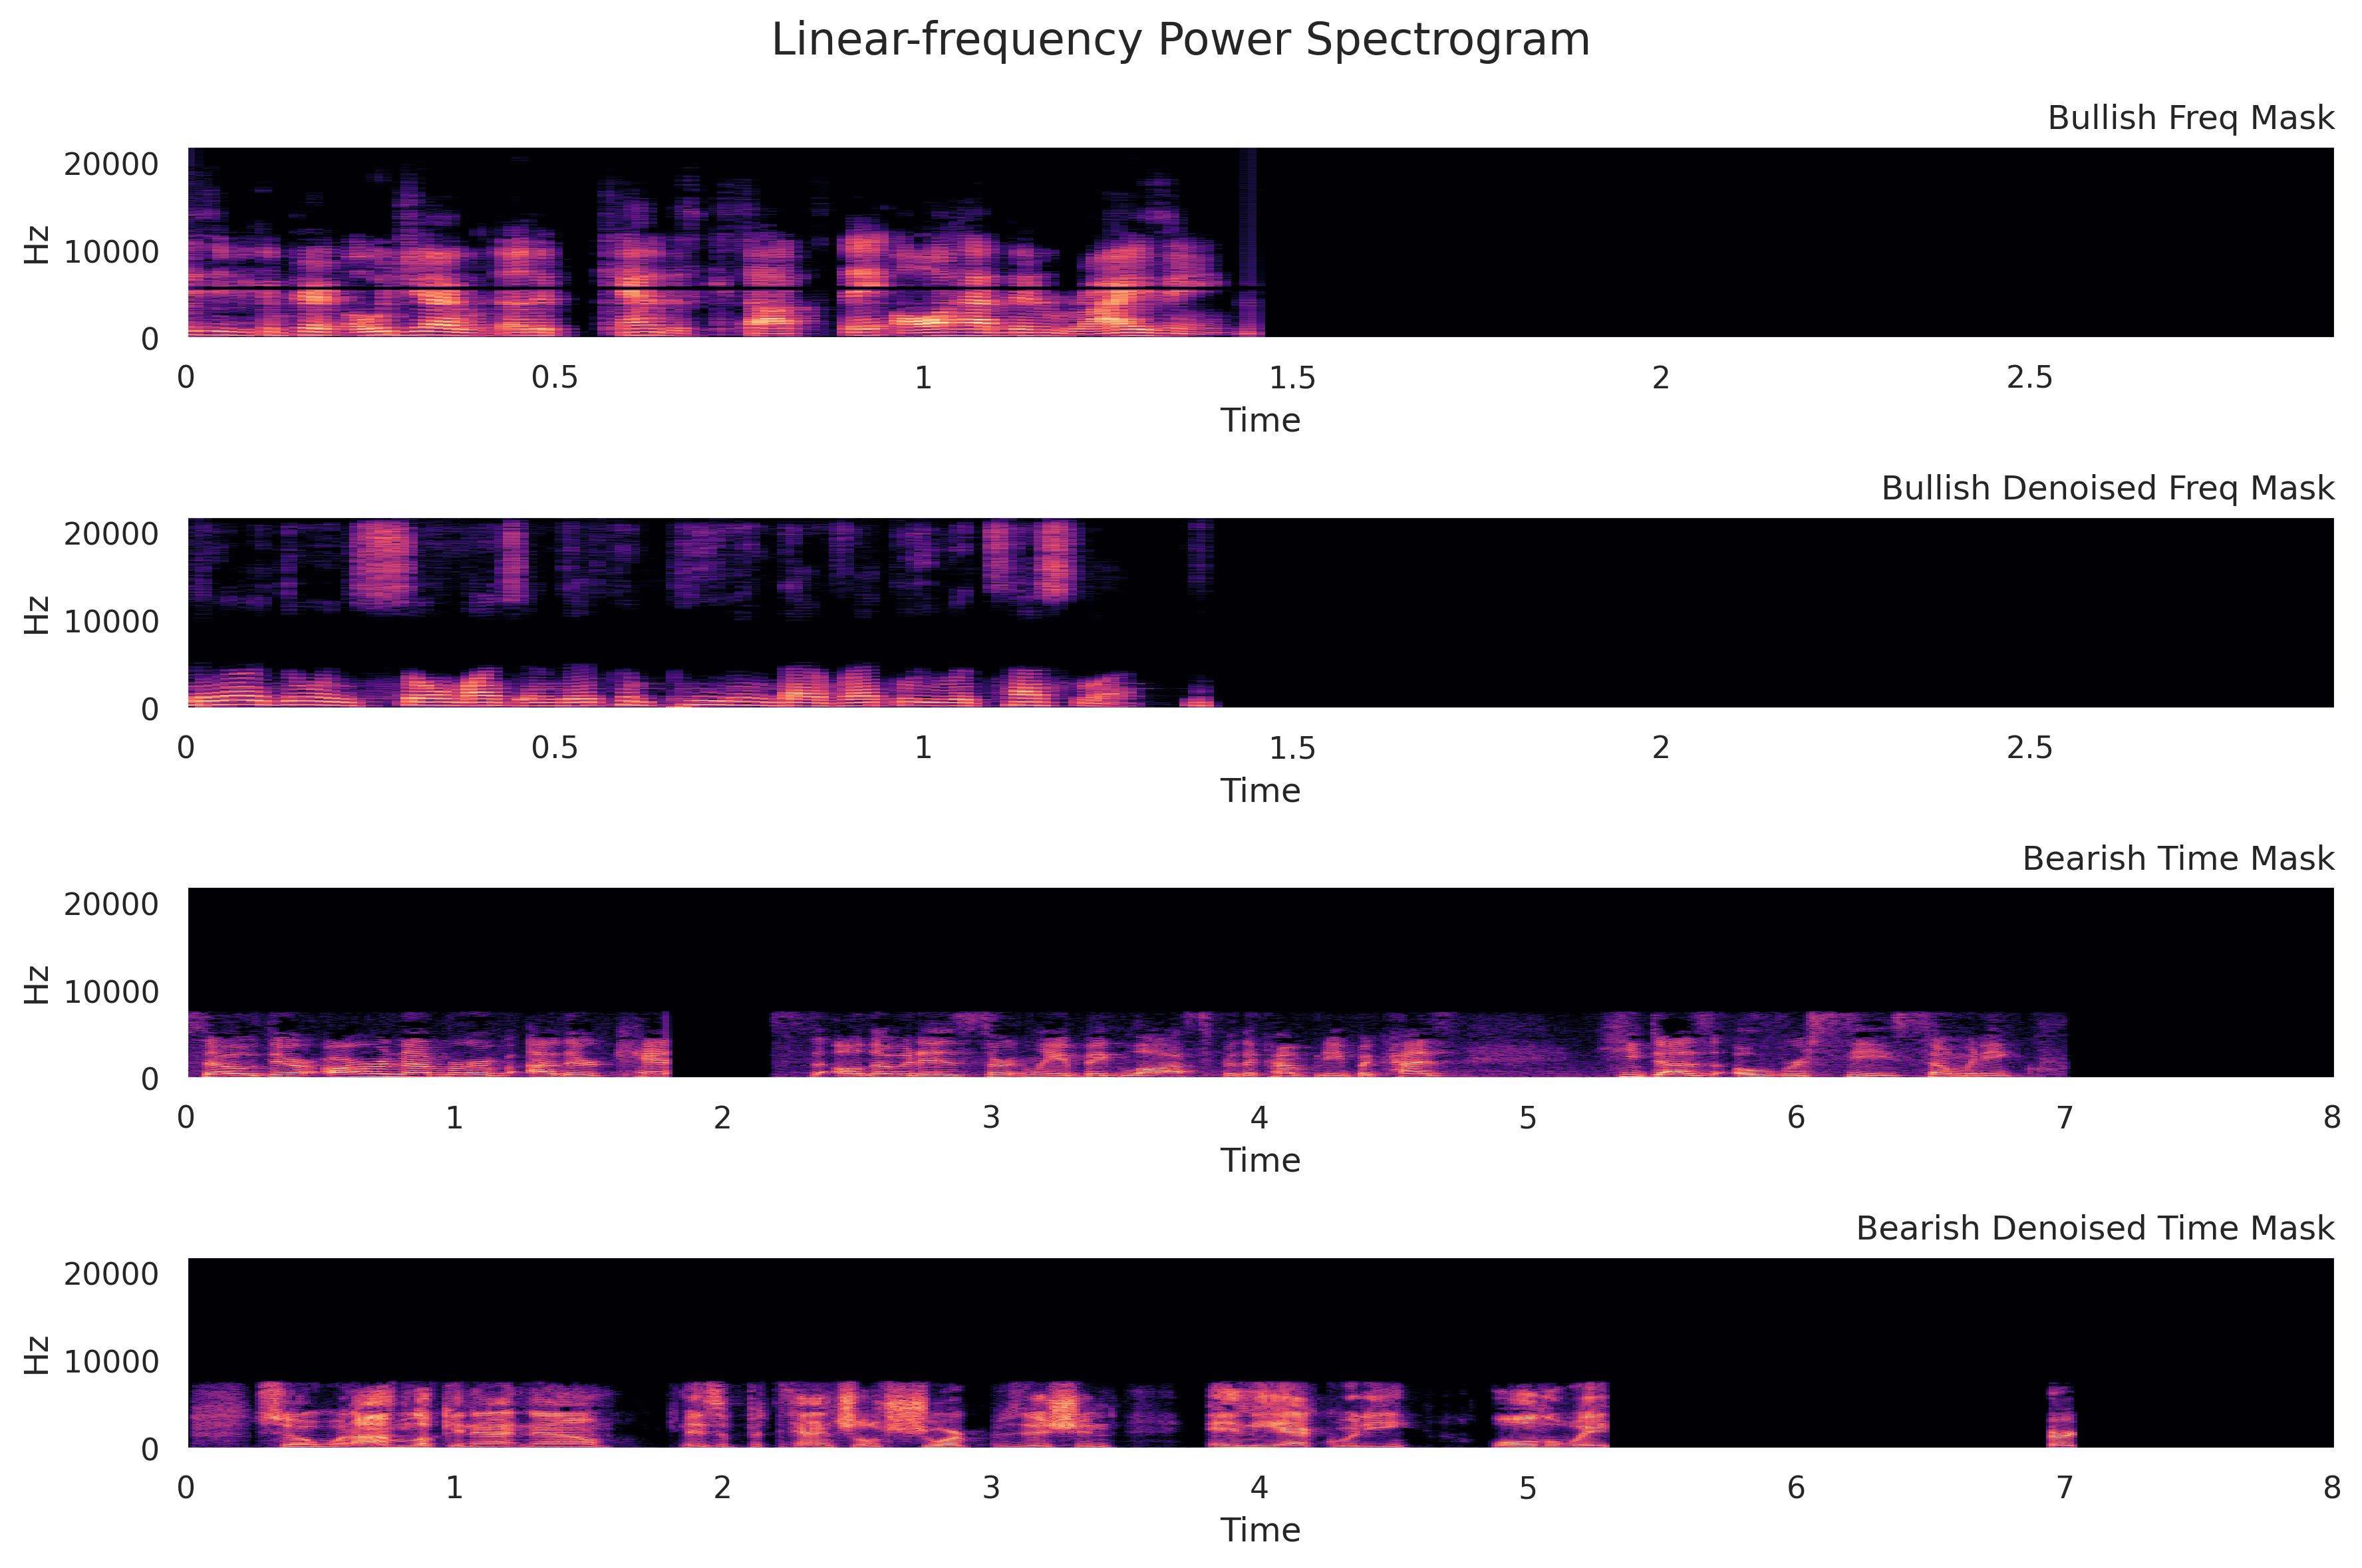

In [251]:
y1_spec = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
y2_spec = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)
y3_spec = librosa.amplitude_to_db(np.abs(librosa.stft(y3)), ref=np.max)
y4_spec = librosa.amplitude_to_db(np.abs(librosa.stft(y4)), ref=np.max)


plt.figure(figsize=(12,8))
plt.suptitle('Linear-frequency Power Spectrogram', fontsize=16)

plt.subplot(4, 1, 1)
librosa.display.specshow(y1_spec, y_axis='linear', x_axis='time', sr=sr)
plt.title('Bullish Freq Mask', loc='right')

plt.subplot(4, 1, 2)
librosa.display.specshow(y2_spec, y_axis='linear', x_axis='time', sr=sr)
plt.title('Bullish Denoised Freq Mask', loc='right')

plt.subplot(4, 1, 3)
librosa.display.specshow(y3_spec, y_axis='linear', x_axis='time', sr=sr)
plt.title('Bearish Time Mask', loc='right')

plt.subplot(4, 1, 4)
librosa.display.specshow(y4_spec, y_axis='linear', x_axis='time', sr=sr)
plt.title('Bearish Denoised Time Mask', loc='right')

plt.tight_layout()

In [288]:
train_OS_df3.to_csv('./capstone-project-3/data/train_OS.csv', index=False)

In [282]:
# Listen to augmentations

IPython.display.Audio(t_bearish_denoised['audio_file'].iloc[16366])

## Conclusion

Through 4 different types of augmentations, we were able to create our new oversampled dataset (train_OS). These augmentations were: 
- Sample denoising
- Sample shifting
- Sample frequency mask
- Sample time mask

In total we were able to gather 49,104 new bearish samples, 60,192 new bullish samples and then 17,801 new neutral samples. By oversampling we are able to create a more "balanced" dataset that we can utilize during model training without manipulating the original dataset distribution which will then be evaluated on. All samples still retain their length of 8 seconds and original sample rate of 16000Hz. 